# The Oscars

## Librerías y lectura de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings("ignore")

In [3]:
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["figure.dpi"] = 120
sns.set_theme(style="whitegrid", palette="muted")

In [5]:
df = pd.read_csv("data/master_dataset.csv")
print(f"Shape: {df.shape}")
df.head(3)

Shape: (170, 62)


,ceremony_year,nominated_title,won_best_picture,tmdb_id,tmdb_title,synopsis,tagline,budget,revenue,runtime_min,...,genre_comedy,genre_biography,genre_history,genre_romance,genre_thriller,genre_war,rt_norm,imdb_norm,metacritic_norm,critic_composite
0,2025,Anora,1,1064213,Anora,A young sex worker from Brooklyn gets her chan...,Love is a hustle.,6000000,56286295,139,...,1,0,0,1,0,0,93.0,74.0,91.0,86.000000
1,2025,The Brutalist,0,549509,The Brutalist,When an innovative modern architect flees post...,Welcome to America.,9600000,50145227,215,...,0,0,0,0,0,0,93.0,73.0,90.0,85.333333
2,2025,A Complete Unknown,0,661539,A Complete Unknown,"New York, early 1960s. Against the backdrop of...",The ballad of a true original.,65000000,138003641,140,...,0,0,0,0,0,0,82.0,73.0,70.0,75.000000


## Valores Faltantes

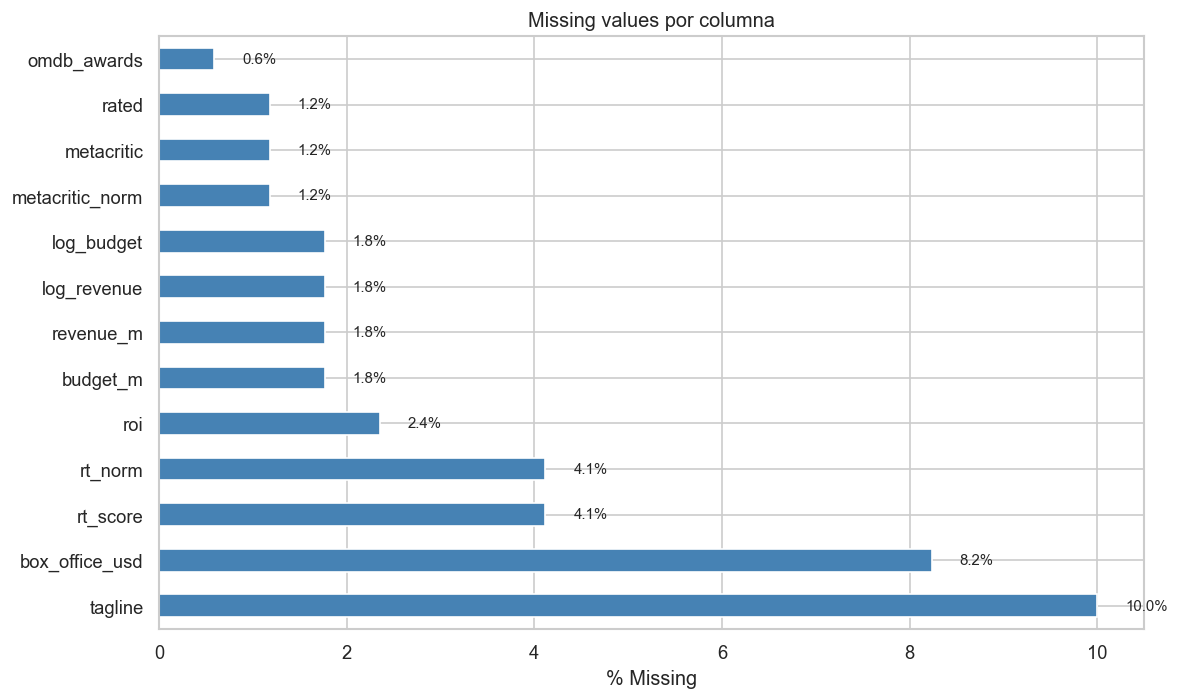

In [6]:
missing = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
missing = missing[missing > 0]

fig, ax = plt.subplots(figsize=(10, 6))
missing.plot(kind="barh", ax=ax, color="steelblue")
ax.set_xlabel("% Missing")
ax.set_title("Missing values por columna")
for i, v in enumerate(missing):
    ax.text(v + 0.3, i, f"{v:.1f}%", va="center", fontsize=9)
plt.tight_layout()
plt.show()

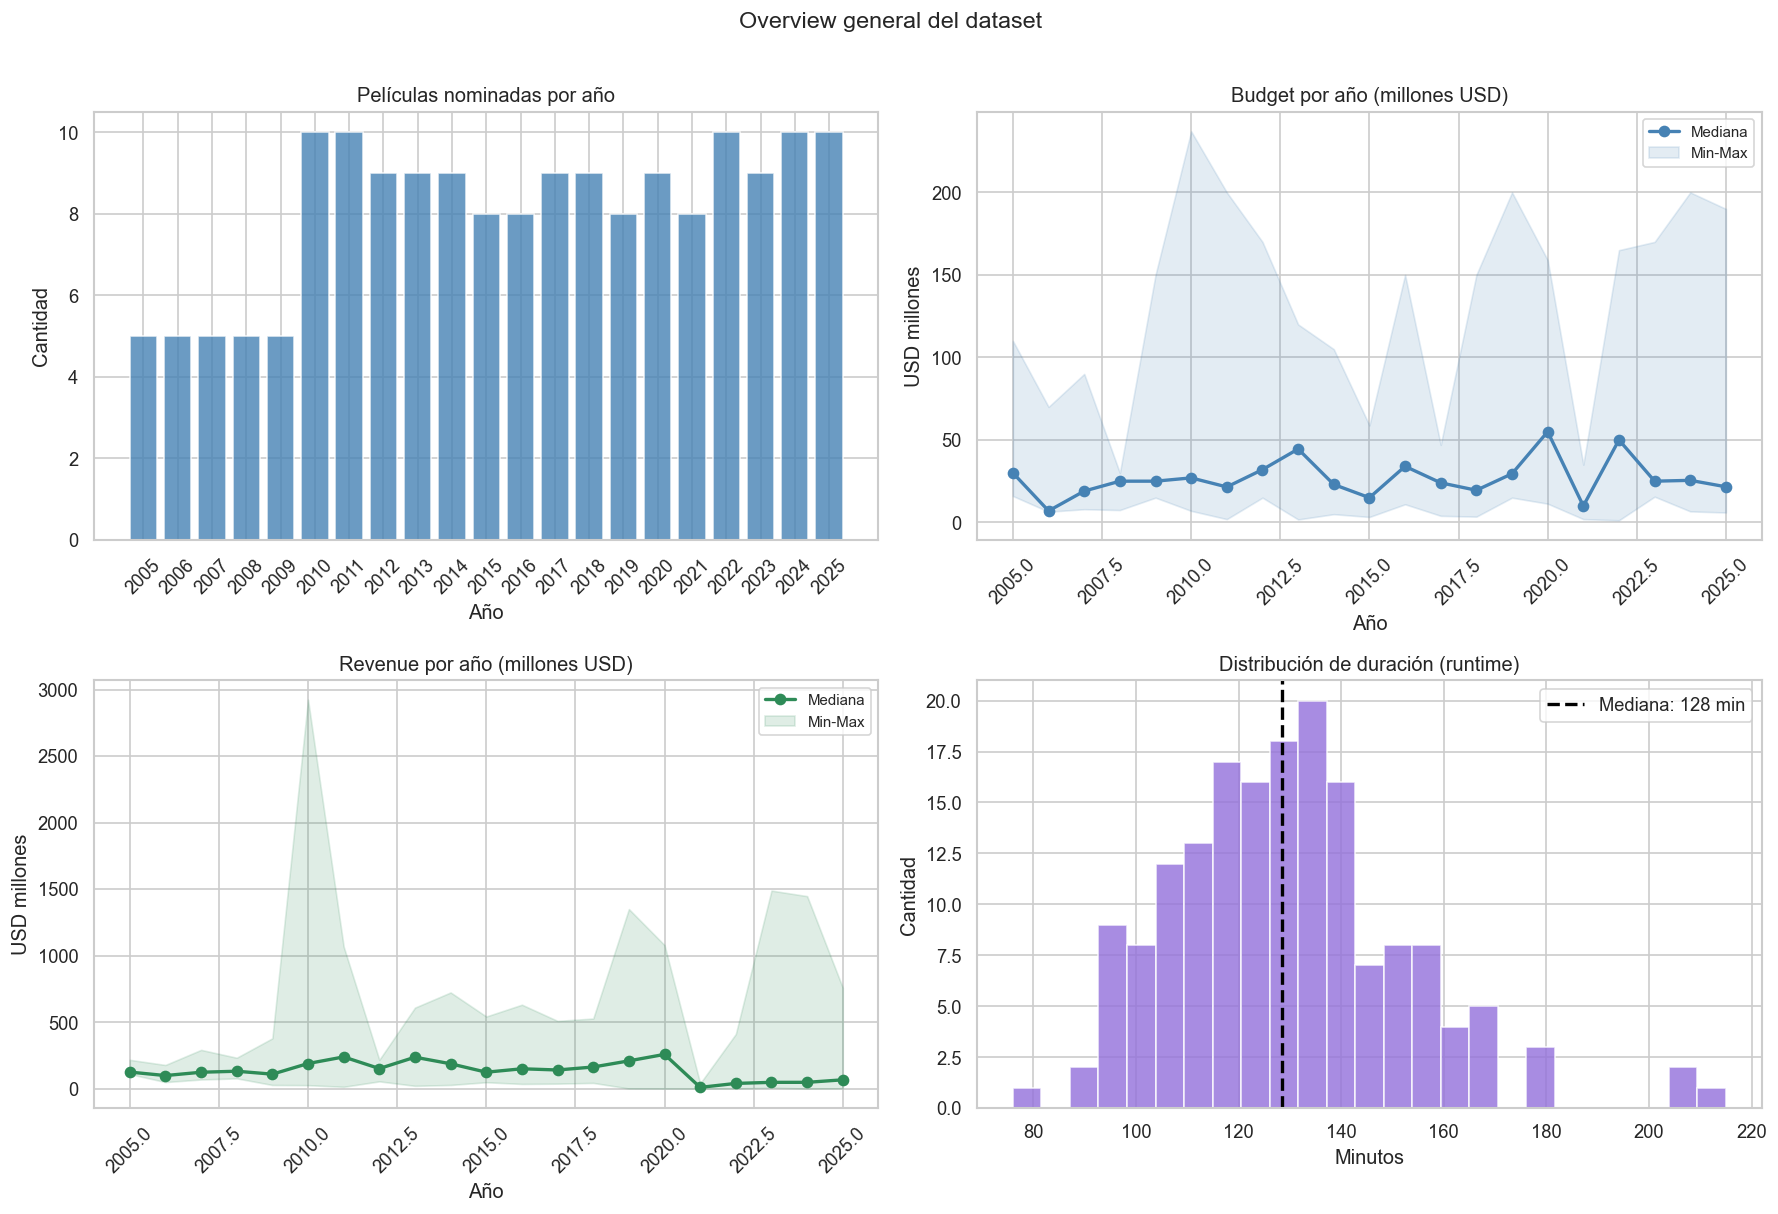

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# ── Nominadas por año ──────────────────────────────────────────────────
ax = axes[0, 0]
noms_per_year = df.groupby("ceremony_year").size()
ax.bar(noms_per_year.index, noms_per_year.values, color="steelblue", alpha=0.8)
ax.set_title("Películas nominadas por año")
ax.set_xlabel("Año")
ax.set_ylabel("Cantidad")
ax.set_xticks(noms_per_year.index)
ax.tick_params(axis="x", rotation=45)

# ── Budget por año ─────────────────────────────────────────────────────
ax = axes[0, 1]
stats = df.groupby("ceremony_year")["budget_m"].agg(["median", "min", "max"])
ax.plot(stats.index, stats["median"], marker="o", color="steelblue", linewidth=2, label="Mediana")
ax.fill_between(stats.index, stats["min"], stats["max"], alpha=0.15, color="steelblue", label="Min-Max")
ax.set_title("Budget por año (millones USD)")
ax.set_xlabel("Año")
ax.set_ylabel("USD millones")
ax.legend(fontsize=9)
ax.tick_params(axis="x", rotation=45)

# ── Revenue por año ────────────────────────────────────────────────────
ax = axes[1, 0]
stats = df.groupby("ceremony_year")["revenue_m"].agg(["median", "min", "max"])
ax.plot(stats.index, stats["median"], marker="o", color="seagreen", linewidth=2, label="Mediana")
ax.fill_between(stats.index, stats["min"], stats["max"], alpha=0.15, color="seagreen", label="Min-Max")
ax.set_title("Revenue por año (millones USD)")
ax.set_xlabel("Año")
ax.set_ylabel("USD millones")
ax.legend(fontsize=9)
ax.tick_params(axis="x", rotation=45)

# ── Runtime ────────────────────────────────────────────────────────────
ax = axes[1, 1]
ax.hist(df["runtime_min"].dropna(), bins=25, color="mediumpurple", alpha=0.8, edgecolor="white")
ax.axvline(df["runtime_min"].median(), color="black", linestyle="--", linewidth=2,
           label=f"Mediana: {df['runtime_min'].median():.0f} min")
ax.set_title("Distribución de duración (runtime)")
ax.set_xlabel("Minutos")
ax.set_ylabel("Cantidad")
ax.legend()

plt.suptitle("Overview general del dataset", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

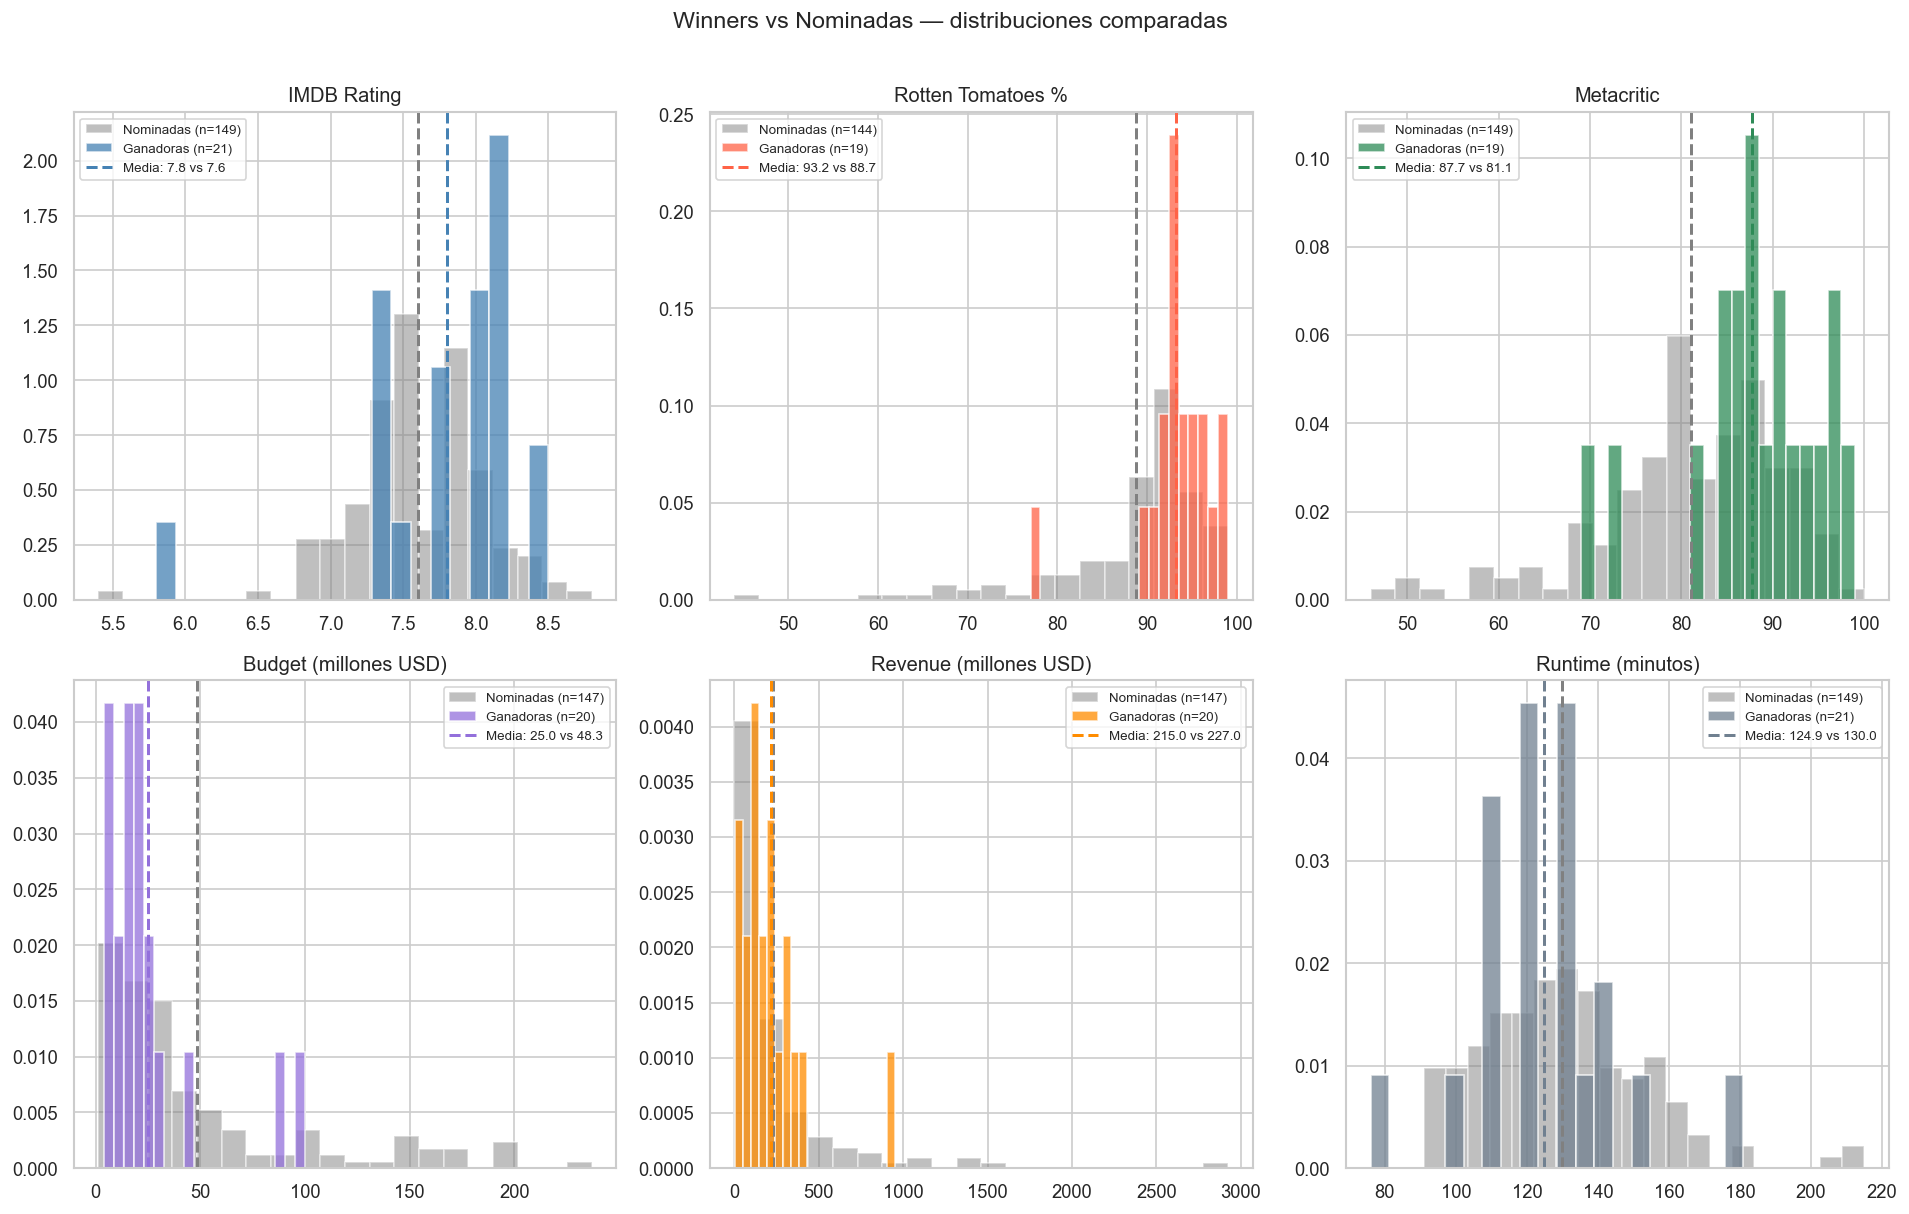

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

comparisons = [
    ("imdb_rating",          "IMDB Rating",            "steelblue"),
    ("rt_score",             "Rotten Tomatoes %",      "tomato"),
    ("metacritic",           "Metacritic",             "seagreen"),
    ("budget_m",             "Budget (millones USD)",  "mediumpurple"),
    ("revenue_m",            "Revenue (millones USD)", "darkorange"),
    ("runtime_min",          "Runtime (minutos)",      "slategray"),
]

for ax, (col, title, color) in zip(axes.flat, comparisons):
    winners = df[df["won_best_picture"] == 1][col].dropna()
    losers  = df[df["won_best_picture"] == 0][col].dropna()

    ax.hist(losers,  bins=20, alpha=0.5, color="gray",  label=f"Nominadas (n={len(losers)})",  density=True)
    ax.hist(winners, bins=20, alpha=0.75, color=color,  label=f"Ganadoras (n={len(winners)})", density=True)

    ax.axvline(losers.mean(),  color="gray",  linestyle="--", linewidth=1.8)
    ax.axvline(winners.mean(), color=color,   linestyle="--", linewidth=1.8,
               label=f"Media: {winners.mean():.1f} vs {losers.mean():.1f}")

    ax.set_title(title)
    ax.legend(fontsize=8)

plt.suptitle("Winners vs Nominadas — distribuciones comparadas", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()